In [1]:
import numpy as np
np.random.seed(0) 

import argparse

import os
import math
from math import sin

import json

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

import seaborn as sns

import wandb

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary
from torch.optim import LBFGS

torch.manual_seed(0)

i_seed = 0

from datetime import datetime
import pytz
import pprint

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from plotting_tools import *
from setting import *

# from EE_extension.dataset_util import *

from VO2_extension.models import *
from VO2_extension.models_CNNlight import *
from VO2_extension.SDT import *
# from models_CNN import *
# from models_CNN2 import *
# from VO2_extension.models_resnet import *
from VO2_extension.dataset_util import *
from VO2_extension.training_util import *
from VO2_extension.evaluation_util import *

from evaluate import *

from stage3_preprocess import *
from stage4_regression import *
from dataIO import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [ ]:
# # # import torch
# # import torch.fft
# # # torch.fft.
# # # torch.__version__
# # # _
# torch.fft.fft

In [33]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='101')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../../data/stage3/win60_overlap90/', 
                          '--output_folder', '../../../data/stage4/DFR_DL/TEST/',
                          '--training_params_file', 'training_params_baseline.json',
                          # '--training_params_file', 'training_params_dummy.json',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../../data/stage3/win60_overlap90/', output_folder='../../../data/stage4/DFR_DL/TEST/', subject_id='101', training_params_file='training_params_baseline.json')


# start timing

In [34]:

tz_NY = pytz.timezone('America/New_York') 
datetime_start = datetime.now(tz_NY)
print("start time:", datetime_start.strftime("%Y-%b-%d %H:%M:%S"))



start time: 2023-Mar-15 14:57:58


In [35]:
# get_regressor_names

In [36]:
inputdir = args.input_folder
outputdir = args.output_folder
training_params_file = args.training_params_file

if not os.path.exists(outputdir):
    os.makedirs(outputdir)


# get training params and dataloaders

In [37]:
torch.cuda.is_available()

True

In [38]:
outputdir

'../../../data/stage4/DFR_DL/TEST/'

In [39]:
label_range_dict['HR_DL'] = [40, 190]

def update_freq_meta(training_params):
    # change the FS_Extracted at the last layer of conv net based on n_block
    FS_Extracted = training_params['FS_RESAMPLE_DL'] / (training_params['stride']**training_params['n_block'])
    training_params['FS_Extracted'] = FS_Extracted
    
    # compute last layer dimension based on n_block
    last_layer_dim = training_params['data_dimensions'][-1]
    for n in range(training_params['n_block']):
        last_layer_dim = round(last_layer_dim/training_params['stride'])

    # training_params['last_layer_dim'] = last_layer_dim

    # compute xf based on FS_Extracted and a mask + xf_masked using xf and label_range_dict['HR_DL']
    xf = np.linspace(0.0, 1.0/2.0*FS_Extracted , last_layer_dim//2)*60    
    
    
    if 'HR' in training_params['auxillary_tasks'][0]:
        freq_range = label_range_dict['HR_DL']
    elif 'RR' in training_params['auxillary_tasks'][0]:
        freq_range = label_range_dict['RR']

    mask = (xf>=freq_range[0]) & (xf<=freq_range[1])

    

    xf_raw = np.linspace(0.0, 1.0/2.0*training_params['FS_RESAMPLE_DL'] , training_params['data_dimensions'][-1]//2)*60    
    raw_mask = (xf_raw>=freq_range[0]) & (xf_raw<=freq_range[1])

    xf_dict = {
        'xf': xf,
        'xf_masked': xf[mask],
        'mask': mask,
        'raw_mask': raw_mask,
        'FS_Extracted': FS_Extracted,
        'last_layer_dim': last_layer_dim,
        'freq_range': freq_range
    }
    # training_params['xf'] = xf
    # training_params['xf_masked'] = xf[mask]
    # training_params['mask'] = mask
    
    return xf_dict


In [ ]:
# training_params['xf_dict']['xf_masked'].shape, training_params['xf_dict']['xf'].shape

In [40]:
def inspect_signals(training_params, dataloaders):
    fig, axes = plt.subplots(training_params['data_dimensions'][0],1, figsize=(50,3), dpi=80)
    for i, ax in enumerate(axes):
        ax.plot(dataloaders['train'].dataset.data[0,i,:])

    for ax in axes:
        ax_no_top_right(ax)

In [41]:
# torch.device('cuda:{}'.format(int(1)) if torch.cuda.is_available() else 'cpu')
# training_params['output_names']

data dimensions are: (1748, 2, 6000)
feature dimensions are: (1748, 2)
label dimensions are: (1748, 3)
meta dimensions are: (1748, 2)


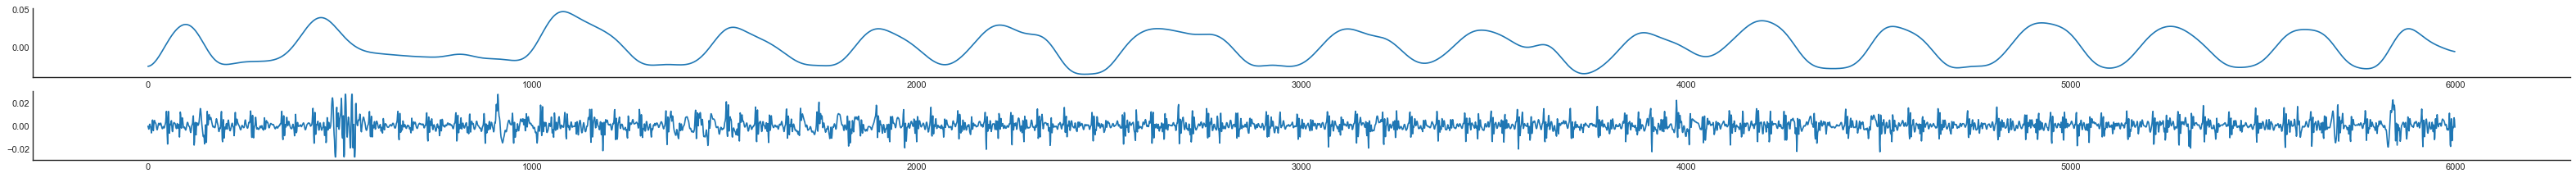

In [42]:
with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)

for training_params in [training_params_list[0]]:
    # include device in training_params
    
    if training_params['cuda_i']==-1:
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
    training_params['device'] = device
    
    if 'training_mode' in training_params:
        training_mode = training_params['training_mode']
    else:
        training_params = 'subject_ind'

    task_id = [0, 1, 2, 3, 4, 5]
    # task_id = [0]
    # task_id = [1, 2]

    training_params['CV_config'] = {
        'subject_id': 113,
        'task_ids': task_id,
        # 'reject_subject_id': [101, 102, 103, 104, 105, 109]
        'reject_subject_id': [101, 102, 103, 105, 109, 115]

        # 'task_id': 5,
    }
    
    training_params['output_names'] = training_params['main_task'] + training_params['auxillary_tasks']
    
    
    # sys.exit()
    
    training_params['regression_names'] = get_regression_names(training_params)

    stage3_dict = data_loader('stage3_dict', inputdir).item()
    training_params['list_signal'] = stage3_dict['list_signal']
    training_params['list_feature'] = stage3_dict['list_feature']
    training_params['list_output'] = stage3_dict['list_output']
    training_params['list_meta'] = stage3_dict['list_meta']
    training_params['FS_RESAMPLE_DL'] = stage3_dict['FS_RESAMPLE_DL']
    training_params['subject_ids'] = stage3_dict['subject_ids']
    training_params['task_ids'] = stage3_dict['task_ids']
    training_params['sequence'] = stage3_dict['sequence']
    
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)
    print('data dimensions are:', dataloaders['train'].dataset.data.shape)
    print('feature dimensions are:', dataloaders['train'].dataset.feature.shape)
    print('label dimensions are:', dataloaders['train'].dataset.label.shape)
    print('meta dimensions are:', dataloaders['train'].dataset.meta.shape)

    data_dimensions = dataloaders['train'].dataset.__getitem__(0)[0].size()
    training_params['data_dimensions'] = list(data_dimensions)
    
    inspect_signals(training_params, dataloaders)

    
    sweep_name = training_params['sweep_name'] 
    
    if training_params['model_name'] == 'FeatureExtractor_CNN':
        training_params['featrue_extractor'] = FeatureExtractor_CNN
    elif training_params['model_name'] == 'ResNet1D':
        training_params['featrue_extractor'] = ResNet1D
    elif training_params['model_name'] == 'FeatureExtractor_CNN2':
        training_params['featrue_extractor'] = FeatureExtractor_CNN2
    elif 'CNNlight' in training_params['model_name']: # designed for HR estimation
        training_params['feature_extractor'] = FeatureExtractor_CNNlight


    # get the right regressor
    if training_params['regressor_type'] == 'DominantFreqRegression':
        training_params['regressor'] = DominantFreqRegression
    elif training_params['regressor_type'] == 'FFTRegression':
        training_params['regressor'] = FFTRegression
    elif training_params['regressor_type'] == 'CardioRespRegression':
        training_params['regressor'] = CardioRespRegression       
    elif training_params['regressor_type'] == 'vanilla_regression':
        training_params['regressor'] = vanilla_regression
    elif training_params['regressor_type'] == 'CardioRespXGBRegression':
        training_params['regressor'] = CardioRespRegression   
    


    if training_params['auxillary_regressor_type'] == 'DominantFreqRegression':
        training_params['auxillary_regressor'] = DominantFreqRegression

    # order subject so we can see the worst subjects first
    if 'ordered_subject_ids' in training_params:
        training_params['ordered_subject_ids'] = np.asarray(training_params['ordered_subject_ids'])
    else:
        training_params['ordered_subject_ids'] = training_params['subject_ids']
    
    training_params['inputdir'] = inputdir
    training_params['outputdir'] = outputdir
    
    # training_params['regression_names'] = get_regression_names(training_params)

    if 'LSTM' in training_params['model_name']:
        training_params = change_output_dim(training_params)

    
    training_params['xf_dict'] = update_freq_meta(training_params)


    
    del dataloaders
# training_params = training_params_list[0]

In [87]:
# dataloaders, dataset_sizes = get_loaders(inputdir, training_params)


In [119]:
# sig = dataloaders['train'].dataset.data[0,0,:]
# sig1 = dataloaders['train'].dataset.data[100,0,:]

# # plt.plot(sig)

In [118]:
# xf, yf = get_psd(sig, Fs=training_params['FS_RESAMPLE_DL'])
# mask = (xf>=FILT_RESP[0]) & (xf<=FILT_RESP[1])
# xf, yf = xf[mask], yf[mask]

In [88]:
xf, yf = get_psd(sig1, Fs=training_params['FS_RESAMPLE_DL'])
mask = (xf>=FILT_RESP[0]) & (xf<=FILT_RESP[1])
xf, yf = xf[mask], yf[mask]

In [148]:
class SNR_attention_module(nn.Module):
    """
    This function comptues the SNR (0~1) for each channel of deep spectral feature
    
    Reference | 
    [1] G. de Haan and V. Jeanne, “Robust Pulse Rate From Chrominance-Based rPPG,” IEEE Transactions on Biomedical Engineering, vol. 60, no. 10, pp. 2878–2886, Oct. 2013, doi: 10.1109/TBME.2013.2266196.
    """

    def __init__(self,):
        super(SNR_attention_module, self).__init__()

#         if xf_dict is None:
#             self.xf_dict = training_params['xf_dict']
#         else:
#             self.xf_dict = xf_dict
            
#         self.xf_masked = torch.from_numpy(self.xf_dict['xf_masked']).float()
        # self.mask = torch.from_numpy(self.xf_dict['mask'])

        # self.avg_pool = nn.AdaptiveAvgPool1d((self.xf_masked.shape[0]))
        self.avg_pool = MyAvgPool1dPadSame(kernel_size=2, stride=1)
        self.max_pool = nn.AdaptiveMaxPool1d((1))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, sig_fft):
        # print('SNR attention_module')
        # sig_fft dim: (N_batch, 1, N_spectral)
        sig_fft = self.avg_pool( sig_fft )
        # SNR dim: (N_batch, N_ch, 1)
        SNR = self.max_pool(sig_fft) / torch.sum(sig_fft, axis=-1, keepdim=True)
        SNR = torch.log(SNR)/ torch.log(torch.tensor(10))

        # SNR_attention dim: (N_batch, N_ch, 1)
        SNR_attention = soft_max(SNR)

        return SNR_attention

In [185]:
get_SNR_attention = SNR_attention_module()

In [301]:
s1 = torch.rand(1, 1, 30)
m = nn.Conv1d(1, 10, kernel_size=1, stride=1)
m(s1).size()


torch.Size([1, 10, 30])

In [186]:
t1.size()

torch.Size([3, 2, 55])

tensor([[[0.6871],
         [0.3129]],

        [[0.6871],
         [0.3129]],

        [[0.6871],
         [0.3129]]], dtype=torch.float64) torch.Size([3, 2, 1])


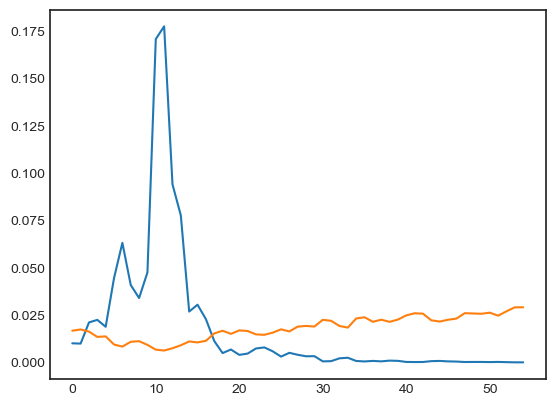

In [244]:
avg_pool = MyAvgPool1dPadSame(kernel_size=2, stride=1)
max_pool = nn.AdaptiveMaxPool1d((1))
soft_max = nn.Softmax(dim=1)

# def forward(self, sig):
# print('SNR attention_module')
# sig dim: (N_batch, 1, N_spectral)
t1 = torch.tensor(yf[None,None,:])
t1 = t1 / t1.sum(axis=-1)

# t2 = (1-t1)+1

t2 = torch.log(t1)/ torch.log(torch.tensor(10))
t2 = t2 / t2.sum(axis=-1)


t1 = torch.cat([t1, t1, t1] , axis=0)
t2 = torch.cat([t2, t2, t2] , axis=0)
t3 = torch.cat([t1, t2] , axis=1)

t3 = avg_pool( t3 )
# SNR dim: (N_batch, N_ch, 1)
SNR = max_pool(t3) / torch.sum(t3, axis=-1, keepdim=True)
SNR = torch.log(SNR)/ torch.log(torch.tensor(10))

atn = soft_max(SNR)
plt.plot(t3[0,0,:])
plt.plot(t3[0,1,:])
# print(SNR, SNR.size())
print(atn, atn.size())
# m = nn.Softmax(dim=1)


In [258]:
def sigmoid(x, scale=1):
    return torch.exp(scale*x)/(1+torch.exp(scale*x)) 

# t1 = torch.tensor(yf[None,None,:])
# t1 = t1 / t1.sum()



# t3_pool = avg_pool(t3)
# t3_mask = sigmoid(t3_pool-torch.mean(t3_pool, axis=-1)*5, scale=100)
# # t1 = torch.arange(1, 13)
# t1 = t1 / t1.max()
  
# display
# plt.plot(t3.squeeze(), 'r')
# plt.plot(t3_pool.squeeze(), 'g')
  
# Compute the logistic sigmoid 
# function of elements in the
# above tensor
# plt.plot(t1_mask.squeeze())

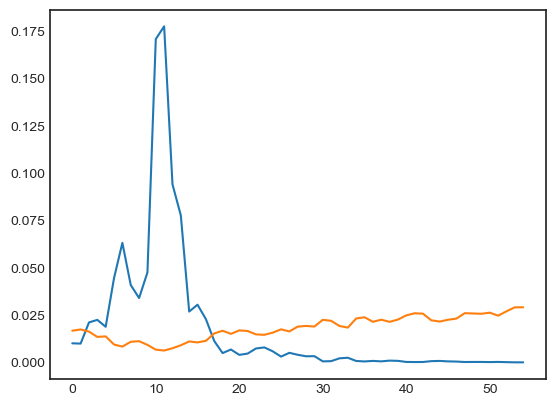

In [246]:
plt.plot(t3[0,:,:].T)
plt.show()

In [252]:

class spectral_attention_module(nn.Module):
    """
    This function create a mask in the spectral domain (spectral hard attention)
    """
    def __init__(self, training_params, xf_dict=None):
        super(spectral_attention_module, self).__init__()
#         self.fft_layer = FFT_layer()
        
        if xf_dict is None:
            self.xf_dict = training_params['xf_dict']
        else:
            self.xf_dict = xf_dict

        self.xf_masked = torch.from_numpy(self.xf_dict['xf_masked']).float()
        self.mask = torch.from_numpy(self.xf_dict['mask'])
        
        
        freq_smooth_dur = 5 # bpm
        freq_smooth_win = round(freq_smooth_dur / np.mean(np.diff(self.xf_masked.data.numpy())))
        self.avg_pool = MyAvgPool1dPadSame(kernel_size=2, stride=1)
        
    def forward(self, sig_fft):
        # print('attention_module')
        # attention dim: (N_batch, 1, N_spectral)
        # attention = self.fft_layer(sig)
        # attention = attention[:,:,self.mask]
        
        attention = self.avg_pool(sig_fft)
        
        # attention dim: (N_batch, 1, N_spectral)
        attention = attention / torch.sum(attention, axis=-1)
        
        # attention = torch.log(attention)/ torch.log(torch.tensor(10))

        # create the mask
        attention = attention > torch.mean(attention, axis=-1, keepdim=True)
        
        # sys.exit()
        return attention

In [ ]:
# AdapTrimm


fc1 = nn.Linear(55, 10)

fc2 = nn.Linear(10, 1)

out = relu(fc1(bn1(x)))
out = fc2(bn2(out))
c = sm(out) # c is between 0 to 1


out = relu(fc1(bn1(x)))
out = fc2(bn2(out))
w = torch.exp(out) # w is > 0 

s = T * sm(c-w/2)
e = T * sm(c+w/2)

Fsampler(Fgrid_gen(x), s, e),


In [259]:
sm = sigmoid(x, scale=1)

NameError: name 'x' is not defined

In [253]:
get_spectral_attention = spectral_attention_module(training_params)

In [254]:
spectral_attention = get_spectral_attention(aaa)

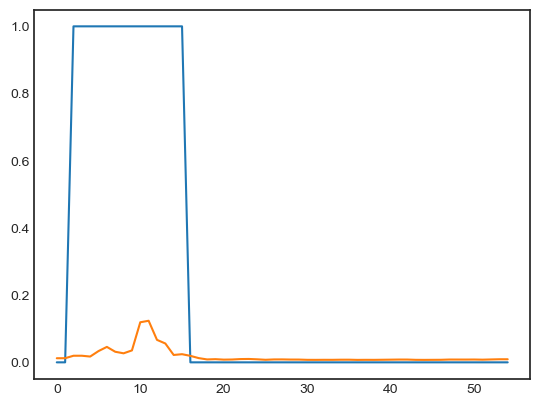

In [255]:
plt.plot(spectral_attention[0,0,:])
plt.plot(aaa[0,0,:])

In [ ]:
# stage3_dict['list_signal']

In [ ]:
# dataloaders, dataset_sizes = get_loaders(inputdir, training_params)
# print(dataloaders['train'].dataset.feature[50,:])

In [ ]:
# # data = dataloaders['train'].dataset.data[:100,:,:]
# plt.plot(dataloaders['train'].dataset.feature[:,0])


In [ ]:
# get_feature_condensed

In [ ]:
# xf, y_matrix_scaled = get_psd(data[:, 0, :], 100)           
# print(xf.shape, y_matrix_scaled.shape)
# plt.plot(xf, y_matrix_scaled[0,:])

# # dim: (N_instance, N_spectral) -> (N_instance, N_spectral_masked)

# # ax_STFT.imshow( y_matrix_scaled[mask, :].T, interpolation='nearest', aspect='auto' ,extent=[t_arr.min(), t_arr.max(), xf[mask].min()*60, xf[mask].max()*60], cmap='viridis')


In [ ]:
# xf, y_matrix_scaled = get_psd(data[0, 0, :], 100)           
# print(y_matrix_scaled.shape)
# plt.plot(y_matrix_scaled)

# # dim: (N_instance, N_spectral) -> (N_instance, N_spectral_masked)

# # ax_STFT.imshow( y_matrix_scaled[mask, :].T, interpolation='nearest', aspect='auto' ,extent=[t_arr.min(), t_arr.max(), xf[mask].min()*60, xf[mask].max()*60], cmap='viridis')


In [ ]:
# data_train, feature_train, label_train, meta_train = get_samples(inputdir, 'train/', training_params)
# data_train.shape, feature_train.shape, label_train.shape, meta_train.shape

In [ ]:
# outputdir = outputdir+training_params['model_name']+'/'
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)
    

# define trainer, evaler, preder functions

In [ ]:
trainer = train_resnet
evaler = eval_resnet
preder = pred_resnet

# some random param
## kernel_size = 5 ~ 16*100/300 (16 for 300 Hz sampling rate, 5 for 100 sampling rate)


In [ ]:
# training_params['downsample_gap']

# # n_block = training_params['n_block_macro'][0] * training_params['downsample_gap'][0]
# # downsample_gap = training_params['downsample_gap'][0]
# # base_filters = training_params['base_filters'][0]
# # use_sc =  training_params['use_sc']
# # increasefilter_gap = downsample_gap * 2
# # kernel_size = training_params['kernel_size']
# # groups = training_params['base_filters'][0]

In [ ]:
if training_params['model_name'] == 'ResNet1D':
# reference: https://github.com/hsd1503/resnet1d/blob/master/test_physionet.py
    training_params['base_filters'] = training_params['channel_n'] # [64] 
    training_params['in_channels'] = training_params['data_dimensions']
#     training_params['increasefilter_gap'] = [training_params['downsample_gap'][0] * 2]
    training_params['n_block'] = training_params['n_block_macro'] * training_params['downsample_gap']
    training_params['increasefilter_gap'] = training_params['downsample_gap']
    

In [ ]:
# # kernel_size = 10 # ~ 16*100/300 (16 for 300 Hz sampling rate, 5 for 100 sampling rate)

# training_params['stride'] = 2
# # stride = 2
# # increasefilter_gap = 12
# # base_filters = 32
# training_params['n_classes'] = 1
# # n_classes = 1 # regression
# training_params['groups'] = 32
# # groups = 32


In [ ]:
# aaa = np.random.rand(5,10)

# i= 7
# aaa[:, i-2:i+5]

In [ ]:
# aaa

# test the model

# TODO: need to fix summary()

In [ ]:
# model = resp_multiverse(training_params=training_params)
# model

In [ ]:
# training_params['data_dimensions']

In [ ]:
# # model
# # print([n for n, _ in model.named_children()])
# try:
# #     model.regressors['EErq_cosmed'].ch_pooling.register_forward_hook(get_activation('aaa'+'_layer_pooling'))
#     print(model.feature_extractors['ppg_ir_1_cardiac'].final_ch_pooling)
# #     model.feature_extractors['ppg_ir_1_cardiac'].final_ch_pooling.register_forward_hook(get_activation('j'+'_layer_pool'))

# except:
#     print('hi')

In [ ]:
def ma_test(training_params):
    print('using model ', training_params['model_name'])

    # prepare model
    model = cardioresp_multiverse(training_params=training_params)
    model = model.to(device).float()

    # prepare data
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)

    data = dataloaders['val'].dataset.data[:5,:,:]
    data = torch.from_numpy(data)

    feature = dataloaders['val'].dataset.feature[:5,:]
    feature = torch.from_numpy(feature)

    label = dataloaders['val'].dataset.label[:5,:]
    label = torch.from_numpy(label)

    data = data.to(device=device, dtype=torch.float)
    feature = feature.to(device=device, dtype=torch.float)
    label = label.to(device=device, dtype=torch.float)

    # model inference
    out = model(data, feature)

    # compute loss
    criterion = MultiTaskLoss(training_params)
    losses = criterion(out, label)

    # check losses
    print(losses)

In [ ]:
def test_model(training_params):

    print('using model ', training_params['model_name'])
    training_params_copy = copy.deepcopy(training_params)
    training_params_copy['device'] = torch.device('cpu')

    model = cardioresp_multiverse(training_params=training_params_copy)
    summary(model, input_size=[tuple(training_params['data_dimensions']), (model.N_features,1)], device='cpu')
    print(model)
    del model


debug_model = True
if debug_model==True:
    if 'LSTM' not in training_params['model_name']:
        test_model(training_params)
    else:
        ma_test(training_params)


In [ ]:
# training_params['']
# model = cardioresp_multiverse(training_params=training_params)
# model

In [ ]:
# np.asarray([[3.5443, 0.6302, 0.8890, 0.2282, 0.0872, 0.5049, 0.7489, 0.6576, 0.3341,
#          0.0189, 0.0549, 0.8110, 0.8436, 0.2467],
#         [2.1010, 0.9481, 0.0459, 0.9481, 0.2327, 0.2986, 0.0566, 0.8680, 0.0354,
#          0.6140, 0.2542, 0.1724, 0.8074, 0.8249]]).shape

In [ ]:
# aaa = np.asarray([2.1401e-02, 5.2948e-02, 4.8660e-02, 2.3125e-02, 1.8792e-02, 4.4786e-02,
#          4.0505e-02, 9.2022e-02, 2.3366e-02, 3.6727e-02, 3.7593e-02, 1.9227e-02,
#          8.0175e-02, 1.1751e-02, 3.3308e-02, 9.9694e-04, 5.6652e-02, 2.9502e-02,
#          6.2231e-02, 2.9936e-02, 2.9115e-01, 2.9982e-02, 6.1280e-02, 1.0757e-02,
#          9.0258e-02, 8.5373e-02, 7.6418e-02, 8.9441e-02, 6.2453e-02, 4.2693e-02,
#          1.5407e-02, 4.7319e-02, 2.5810e-02, 3.5634e-02, 5.3523e-02, 2.9331e-02,
#          3.7448e-02, 1.6395e-03, 4.5737e-02, 9.3887e-03, 3.2670e-04, 1.0972e-01,
#          1.7465e-01, 1.5314e-03, 1.9195e-02, 6.7398e-03, 5.8138e-02, 8.0607e-02,
#          1.2636e-02, 3.3586e-02, 3.7032e-02, 4.9149e-03, 2.2533e-02, 1.2068e-02,
#          1.3842e-02, 3.8260e-02, 4.2759e-02, 3.3205e-02, 6.1934e-03, 1.8395e-02,
#          1.2402e-03, 6.3478e-03, 2.7459e-03, 5.5447e-02, 2.7626e-02, 1.5574e-02,
#          6.3464e-03, 4.4044e-03, 5.1936e-03, 1.9746e-03, 1.3221e-02, 7.7879e-02,
#          7.1552e-02, 4.1376e-02, 2.8416e-02, 9.7569e-04, 1.6641e-02, 2.6640e-02,
#          6.4612e-03, 3.8234e-02, 2.3350e-02, 2.4832e-03, 5.9804e-02, 3.7242e-02,
#          8.2675e-03, 1.1702e-02, 8.3360e-03, 6.0277e-03, 1.4620e-02, 9.3395e-02,
#          8.7535e-03, 1.3427e-02, 8.1653e-03, 1.3704e-03, 1.5250e-02, 2.1366e-02,
#          2.2589e-02, 1.5303e-03, 2.8091e-02, 1.3629e-02, 4.6785e-03, 9.4788e-03,
#          1.9621e-02, 3.3250e-02, 2.3812e-02, 2.9386e-03, 5.2316e-03, 4.3363e-03,
#          2.0358e-02, 8.4607e-03, 3.1620e-03, 1.3839e-02, 1.0665e-02, 1.8921e-02,
#          1.0277e-03, 5.1848e-03, 3.9836e-03, 4.6698e-03, 3.1213e-02, 7.6926e-04,
#          2.9481e-04, 4.6821e-02, 5.5914e-03, 2.1895e-04, 3.9770e-02, 7.8995e-03,
#          1.3295e-02, 6.5317e-03, 1.7513e-02, 3.3253e-02, 1.1863e-02, 1.9118e-02,
#          1.8587e-03, 1.7318e-02, 1.1878e-02, 7.5513e-04, 6.9692e-03, 1.7484e-03,
#          6.6013e-03, 2.0463e-02, 2.8306e-03, 3.3742e-03, 4.0343e-03, 2.6108e-03,
#          5.5981e-03, 1.9416e-02, 5.9020e-03, 3.3385e-03, 4.6520e-03, 2.1423e-03])

# plt.plot(aaa)
# aaa.sum()

In [ ]:
# aaa = np.asarray([1.3937e-01, 1.7408e-02, 8.7188e-03, 3.6859e-03, 2.8539e-02, 3.3135e-03,
#          2.3546e-03, 1.8415e-02, 7.7323e-04, 8.9279e-02, 2.7628e-02, 1.1624e-03,
#          1.4091e-03, 7.6076e-03, 5.5106e-03, 9.0067e-03, 3.3295e-02, 1.8626e-02,
#          5.7293e-03, 1.0103e-02, 1.2345e-02, 1.5024e-02, 7.3515e-03, 5.8552e-03,
#          8.9973e-03, 3.5095e-06, 5.8788e-03, 1.1690e-03, 1.2718e-02, 1.3568e-02,
#          1.1772e-02, 7.0488e-03, 2.4958e-02, 1.1070e-03, 3.5098e-03, 1.5204e-03,
#          3.8619e-03, 1.0562e-02, 9.8544e-04, 1.3186e-03, 1.3311e-02, 4.6455e-03,
#          1.1633e-02, 3.2777e-03, 7.8052e-03, 7.7763e-03, 2.8001e-03, 8.7417e-03,
#          1.5549e-02, 2.5041e-03, 5.5233e-03, 5.4884e-04, 3.4072e-03, 1.9839e-02,
#          9.8067e-04, 4.9376e-03, 1.5395e-02, 8.3741e-03, 2.1704e-02, 3.1926e-04,
#          2.8057e-03, 4.7085e-03, 1.2575e-02, 7.0261e-03, 9.7258e-04, 1.1450e-02,
#          8.3632e-03, 1.8954e-03, 8.3838e-03, 4.7709e-03, 5.0147e-03, 3.7506e-03,
#          8.4175e-04, 5.5039e-03, 1.1216e-02, 1.0396e-02, 2.8943e-03, 7.0636e-03,
#          4.8932e-03, 6.2329e-03, 1.6251e-03, 1.2382e-03, 9.2144e-03, 6.4909e-03,
#          3.8737e-03, 2.6443e-03, 1.0003e-03, 1.8192e-03, 4.7446e-03, 3.7229e-03,
#          1.5805e-03, 6.0741e-04, 3.2795e-03, 8.3908e-04, 2.5659e-03, 1.3761e-04,
#          2.1440e-03, 1.3425e-04, 1.4076e-03, 2.6527e-03, 1.9744e-03, 2.5963e-03,
#          8.8028e-03, 5.9597e-03, 4.2153e-03, 2.0148e-03, 3.2592e-03, 1.6996e-03,
#          2.1871e-04, 7.9804e-04, 1.3802e-03, 1.9110e-03, 4.4874e-03, 7.2803e-03,
#          1.2748e-03, 2.1787e-03, 2.4773e-03, 9.1380e-04, 1.0685e-03, 1.5550e-03,
#          1.6759e-04, 2.1316e-04, 4.3124e-04, 1.3491e-04, 1.4630e-04, 7.0535e-04,
#          8.4301e-05, 1.7137e-03, 8.8226e-04, 5.4867e-04, 1.6905e-03, 3.0111e-03,
#          8.8613e-04, 1.6220e-03, 1.6844e-04, 6.1124e-05, 4.5513e-03, 4.8490e-04,
#          4.7349e-04, 2.8361e-05, 7.4476e-04, 1.4798e-03, 1.4628e-03, 1.2396e-03,
#          2.2785e-03, 1.1905e-03, 3.6243e-03, 1.3961e-04, 2.8770e-04, 4.3434e-04])

# plt.plot(aaa)
# aaa.sum()

In [ ]:
# training_params['FS_Extracted']

In [ ]:
# criterion.loss_weights

In [ ]:
criterion = MultiTaskLoss(training_params)
# criterion

In [ ]:
# training_params['regression_names']

In [ ]:
# training_params['xf_dict']['xf_masked'].shape
# training_params['xf_dict']['last_layer_dim']

In [ ]:
# dataloaders

In [ ]:
# dataloaders, dataset_sizes = get_loaders(inputdir, training_params)

# # data = dataloaders['val'].dataset.data[:5,:,:]
# # data = torch.from_numpy(data)

# # feature = dataloaders['val'].dataset.feature[:5,:]
# # feature = torch.from_numpy(feature)

# label = dataloaders['val'].dataset.label

In [ ]:
# label[:,0,:].mean(axis=-1).shape

In [ ]:
# /6000//4//4//4//4//4

In [ ]:
# out['EErq_cosmedperc'].size(), label.size()

In [ ]:
# a = torch.rand(10,1)
# aaa = []
# aaa.append(a)
# aaa
# # print(a.transpose(0,3).size())
# # print(a.permute(3,2,1,0).size())

In [ ]:
# torch.concat(aaa, -1).size()

In [ ]:
# pytorch_total_params/(10**6)

In [ ]:
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
# del model

# define training, validating, and evaluating funcitons 

In [ ]:
outputdir

## train, val, eval model

In [ ]:
if training_params['wandb']:
    os.environ["WANDB_DIR"] = os.path.abspath(outputdir)
    os.environ["WANDB_NOTEBOOK_NAME"] = 'DL_regression'
    wandb.login()


In [ ]:
# outputdir_numeric = outputdir + 'numeric_results/'
# if outputdir_numeric is not None:
#     if not os.path.exists(outputdir_numeric):
#         os.makedirs(outputdir_numeric)
        
    
# outputdir_modelout = outputdir + 'model_output/'
# if outputdir_modelout is not None:
#     if not os.path.exists(outputdir_modelout):
#         os.makedirs(outputdir_modelout)
        
        

In [ ]:
def get_sweep_folder(training_params):
    n_block = training_params['n_block']
    inputs_combined = '+'.join([ i_name.split('_')[0] for i_name in training_params['input_names']])
    main_weight = training_params['loss_weights']['main_task']
    auxillary_weight = training_params['loss_weights']['auxillary_task']
    channel_n = training_params['channel_n']
    
    auxillary_task = training_params['auxillary_tasks'][0]

    # sweep_folder = '{}blocks-{}-weight{}+{}-{}ch-act{}-{}'.format(n_block, inputs_combined, auxillary_weight, adversarial_weight, channel_n, list_act, training_params['regressor_type'])
    sweep_folder = '{}blocks-{}-weight{}+{}-{}'.format(n_block, inputs_combined, main_weight, auxillary_weight, auxillary_task)

    return sweep_folder


In [ ]:
def get_outputdirs(training_params):

    outputdir = training_params['outputdir']
    sweep_folder = get_sweep_folder(training_params)
    outputdir_sweep = outputdir+'{}/'.format(sweep_folder)

    outputdir_numeric = outputdir_sweep + 'numeric_results/'
    if outputdir_numeric is not None:
        if not os.path.exists(outputdir_numeric):
            os.makedirs(outputdir_numeric)

    outputdir_modelout = outputdir_sweep + 'model_output/'
    if outputdir_modelout is not None:
        if not os.path.exists(outputdir_modelout):
            os.makedirs(outputdir_modelout)

    outputdir_activation = outputdir_sweep + 'activation_layers/'
    if outputdir_activation is not None:
        if not os.path.exists(outputdir_activation):
            os.makedirs(outputdir_activation)

    outputdir_feature = outputdir_sweep + 'feature_visualization/'
    if outputdir_feature is not None:
        if not os.path.exists(outputdir_feature):
            os.makedirs(outputdir_feature)

    training_params['outputdir_sweep'] = outputdir_sweep
    training_params['outputdir_numeric'] = outputdir_numeric
    training_params['outputdir_modelout'] = outputdir_modelout
    training_params['outputdir_activation'] = outputdir_activation
    training_params['outputdir_feature'] = outputdir_feature

    return training_params

In [ ]:
# training_params['CV_config']['subject_id'] = 108

In [ ]:
# training_params['xgb_regressor'] = XGBRegressor(learning_rate=0.05, max_depth=50, subsample=0.6, colsample_bytree=0.7, n_estimators=100, min_child_weight=2, gamma=0.001, verbosity=0)

# dataloaders, dataset_sizes = get_loaders(inputdir, training_params)

# feature_train = dataloaders['train'].dataset.feature
# feature_val = dataloaders['val'].dataset.feature

# label_train = dataloaders['train'].dataset.label[:,[-1]]
# label_val = dataloaders['val'].dataset.label[:,[-1]]

# training_params['xgb_regressor'] = training_params['xgb_regressor'].fit(feature_train, label_train)
# label_est_train = training_params['xgb_regressor'].predict(feature_train)
# label_est_val = training_params['xgb_regressor'].predict(feature_val)


# print(get_df_performance(label_train, label_est_train, 501, 'VO2_cosmed-scg'))
# print(get_df_performance(label_val, label_est_val, 501, 'VO2_cosmed-scg'))

# sys.exit()



In [ ]:
debug_auxillary = False

def train_master(training_params):
    
    training_params['regression_names'] = get_regression_names(training_params)
    training_params = get_outputdirs(training_params) # could be tricky since it changes several keys
    training_params['xf_dict'] = update_freq_meta(training_params)

    pprint.pprint(training_params)
    
    df_performance_train = {}
    df_performance_val = {}

    df_outputlabel_train = {}
    df_outputlabel_val = {}

#     for task in training_params['tasks']:
    for task in training_params['regression_names']:

        df_performance_train[task] = pd.DataFrame()
        df_performance_val[task] = pd.DataFrame()

        df_outputlabel_train[task] = pd.DataFrame()
        df_outputlabel_val[task] = pd.DataFrame()

#     ordered_subject_ids = np.asarray([115, 107, 113, 110, 101, 104, 106, 121, 212, 102, 103, 111, 114, 116, 118, 119, 120])
#     ordered_subject_ids = np.asarray([107, 113, 110, 101, 104, 115, 106, 121, 212, 102, 103, 111, 114, 116, 118, 119, 120])
#         ordered_subject_ids = np.asarray([101, 110, 113, 119, 115, 107, 104, 106, 121, 212, 102, 103, 111, 114, 116, 118, 120])
#     ordered_subject_ids = np.asarray([101, 110, 113, 119, 115])

    ordered_subject_ids = training_params['ordered_subject_ids']
    # main_task = training_params['output_names'][0].split('-')[0]
    main_task = training_params['main_task'][0] # VO2_cosmed

    # for subject_id in training_params['subject_ids']:
    for i_CV, subject_id in enumerate(ordered_subject_ids):
        
        if 'CV_max' in training_params:
            if i_CV >= training_params['CV_max']:
                continue
                
        if subject_id in training_params['CV_config']['reject_subject_id']:
            continue

        training_params['CV_config']['subject_id'] = subject_id

        # device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
        print('using device', training_params['device'])


        print('using model ', training_params['model_name'])

#         training_params = get_regressor_names(training_params)
        model = cardioresp_multiverse(training_params=training_params)
#         print(model)
        
        model = model.to(device).float()
        
        

        

        if training_params['regressor_type']=='CardioRespXGBRegression':
            training_params['xgb_regressor'] = XGBRegressor(learning_rate=0.05, max_depth=50, subsample=0.6, colsample_bytree=0.7, n_estimators=100, min_child_weight=2, gamma=0.001, verbosity=0)

#             dataloaders, dataset_sizes = get_loaders(inputdir, training_params)

#             feature_train = dataloaders['train'].dataset.feature
#             feature_val = dataloaders['val'].dataset.feature

#             label_train = dataloaders['train'].dataset.label
#             label_val = dataloaders['val'].dataset.label

#             training_params['xgb_regressor'] = training_params['xgb_regressor'].fit(feature_train, label_train)
#             label_est_train = training_params['xgb_regressor'].predict(feature_train)
#             label_est_val = training_params['xgb_regressor'].predict(feature_val)


#             print(get_df_performance(label_train, label_est_train, 501, 'VO2_cosmed-scg'))
#             print(get_df_performance(label_val, label_est_val, 501, 'VO2_cosmed-scg'))
        
#             sys.exit()
            
            
            
            
            
            
            
        

        
        if training_params['optimizer_name'] == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=0.1)
        # optimizer = torch.optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=0.9)
        elif training_params['optimizer_name'] == 'LBFGS':
            optimizer =  torch.optim.LBFGS(model.parameters(), history_size=10, max_iter=4)

        criterion = MultiTaskLoss(training_params)
        
        training_params['criterion'] = criterion
        training_params['optimizer'] = optimizer
        training_params['inputdir'] = inputdir
        

        
#         print( training_params['regressor_names'])
        CV_dict = train_model(model, training_params, trainer, evaler, preder)

        # print(CV_dict.keys())
        
        # print(CV_dict['total_losses_train'])
        # sys.exit()

        plot_losses(CV_dict, outputdir=training_params['outputdir_sweep'], show_plot=False, fig_name='loss_{}'.format(subject_id))

        
        ############### IMPLEMENT Deep Learning Logger ###############
        # print(CV_dict.keys())
        # sys.exit()

#         TODO: fix this code
#         print(training_params['regressor_names'])
        
#         for task in CV_dict['performance_dict_train']['out_dict'].keys():
        for task in training_params['regression_names']:
            # if main_task in task:
            #     continue
#             print(task, df_performance_train)

#         for task in training_params['tasks']:

#             print( CV_dict['performance_dict_val']['out_dict'].keys(), CV_dict['performance_dict_val']['label_dict'].keys(), task)
            label_est_val = CV_dict['performance_dict_val']['out_dict'][task]
            label_val = CV_dict['performance_dict_val']['label_dict'][task]

            label_est_train = CV_dict['performance_dict_train']['out_dict'][task]
            label_train = CV_dict['performance_dict_train']['label_dict'][task]
            
            # print(label_train, label_est_train)
            # print(len(label_train), len(label_est_train))
            # print(task, CV_dict['performance_dict_train']['out_dict'].keys(), CV_dict['performance_dict_train']['label_dict'].keys(), label_train.shape, label_est_train.shape)
            
            # rescale the label after making estimations
            if 'perc' in training_params['output_names'][0]:
                i_meta = training_params['meta_names'].index('EEavg_est')
#                 print(CV_dict['performance_dict_train']['meta_arr'], CV_dict['performance_dict_train']['meta_arr'].shape)
                meta_train = CV_dict['performance_dict_train']['meta_arr'][:, i_meta]
                meta_val = CV_dict['performance_dict_val']['meta_arr'][:, i_meta]

                label_train = label_train*meta_train
                label_val = label_val*meta_val
                label_est_train = label_est_train*meta_train
                label_est_val = label_est_val*meta_val
            elif '_weighted' in training_params['output_names'][0]:
                i_meta = training_params['meta_names'].index('weight')
                meta_train = CV_dict['performance_dict_train']['meta_arr'][:, i_meta]
                meta_val = CV_dict['performance_dict_val']['meta_arr'][:, i_meta]

                label_train = label_train*meta_train
                label_val = label_val*meta_val
                label_est_train = label_est_train*meta_train
                label_est_val = label_est_val*meta_val

            
            # get performance df for training and testing dataset
            df_performance_train[task] = df_performance_train[task].append( get_df_performance(label_train, label_est_train, subject_id, task), ignore_index=True )

            df_performance_train[task].to_csv(training_params['outputdir_numeric'] + 'df_performance_train_{}.csv'.format(task), index=False)

            df_outputlabel_train[task] = df_outputlabel_train[task].append(
                pd.DataFrame( {
                'label_est': label_est_train,
                'label': label_train,
                'CV': [subject_id]*label_train.shape[0],
                'task': [task]*label_train.shape[0]
                }), ignore_index=True )

            df_outputlabel_train[task].to_csv(training_params['outputdir_numeric'] + 'df_outputlabel_train_{}.csv'.format(task), index=False)

            df_performance_val[task] = df_performance_val[task].append( get_df_performance(label_val, label_est_val, subject_id, task), ignore_index=True )
            df_performance_val[task].to_csv(training_params['outputdir_numeric'] + 'df_performance_val_{}.csv'.format(task), index=False)

            df_outputlabel_val[task] = df_outputlabel_val[task].append(
                pd.DataFrame( {
                'label_est': label_est_val,
                'label': label_val,
                'CV': [subject_id]*label_val.shape[0],
                'task': [task]*label_val.shape[0]
                }), ignore_index=True )

            df_outputlabel_val[task].to_csv(training_params['outputdir_numeric'] + 'df_outputlabel_val_{}.csv'.format(task), index=False)

            # plot performance training and testing dataset
            # if (main_task not in task) and (debug_auxillary==False):
            #     continue
            
            plot_regression(df_outputlabel_train[task], task, training_params, fig_name='regression_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
            plot_regression(df_outputlabel_val[task], task, training_params, fig_name='regression_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
            # plot_regression(df_outputlabel_train[task], df_performance_train[task], task, fig_name='regression_train_{}'.format(task), show_plot=False, outputdir=outputdir+'model_output/')
#             plot_BA(df_outputlabel_train[task], task, fig_name='BA_train_{}'.format(task), show_plot=False, outputdir=outputdir+'model_output/')

            # plot_regression(df_outputlabel_val[task], task, training_params, fig_name='regression_val_{}'.format(task), show_plot=False, outputdir=outputdir_modelout, log_wandb=training_params['wandb'])
#             plot_BA(df_outputlabel_val[task], task, fig_name='BA_val_{}'.format(task), show_plot=False, outputdir=outputdir+'model_output/')

            # plot_output(df_outputlabel_train[task], task, fig_name = 'outputINtime_train_{}'.format(task), show_plot=False, outputdir=outputdir_modelout)
            plot_output(df_outputlabel_val[task], task, fig_name = 'outputINtime_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'])
        
        
            # TODO: add feature importance
            # if 'XGB' in training_params['model_name']:
            #     plot_feature_importances(training_params['feature_names'], model.feature_importances_, fig_name='feature_importance_'+str(subject_id), outputdir=training_params['outputdir_featureimportance'], show_plot=False, log_wandb=training_params['wandb'])


        # check_featuremap(model, training_params, mode='worst', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=outputdir+'activation_layers_worst/{}/'.format(subject_id), show_plot=False)
        # check_featuremap(model, training_params, mode='best', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=outputdir+'activation_layers_best/{}/'.format(subject_id), show_plot=False)

        if 'CNNlight' in training_params['model_name']:
            check_featuremap(model, training_params, mode='worst', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=training_params['outputdir_activation']+'worst/{}/'.format(subject_id), show_plot=False)
            check_featuremap(model, training_params, mode='best', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=training_params['outputdir_activation']+'best/{}/'.format(subject_id), show_plot=False)
        
        del model
        torch.cuda.empty_cache()


    for task in training_params['regression_names']:
        # if task!=main_task:
        # if main_task in task:
        #     continue
        plot_regression_all_agg(df_outputlabel_train[task], training_params, fig_name='LinearR_agg_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
        plot_BA(df_outputlabel_train[task], task, training_params, fig_name='BA_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])

        plot_regression_all_agg(df_outputlabel_val[task], training_params, fig_name='LinearR_agg_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
        plot_BA(df_outputlabel_val[task], task, training_params, fig_name='BA_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])

        plot_output(df_outputlabel_val[task], task, fig_name = 'outputINtime_val_{}'.format(task),  show_plot=False, outputdir=training_params['outputdir_modelout'])

#     plot_BA(df_outputlabel_val[main_task], main_task, fig_name='BA_val_{}'.format(main_task), show_plot=False, outputdir=outputdir+'model_output/', log_wandb=training_params['wandb'])
#     plot_regression_all_agg(df_outputlabel_val[main_task], df_performance_val[main_task], outputdir=outputdir+'model_output/', show_plot=False, log_wandb=training_params['wandb'])

    # log metrices on wnadb
    if training_params['wandb']==True:
        
        task = training_params['regression_names'][-1]
        # W&B
        label = df_outputlabel_val[task]['label'].values
        label_est = df_outputlabel_val[task]['label_est'].values
    
        PCC = get_PCC(label, label_est)
        Rsquared = get_CoeffDeterm(label, label_est)
        MAE, _ = get_MAE(label, label_est)
        RMSE = get_RMSE(label, label_est)
        MAPE, _ = get_MAPE(label, label_est)
        
        # print()

        wandb.log(
            {
                'val_MAE': MAE,
                'val_RMSE': RMSE,
                'val_MAPE': MAPE,
                'val_PCC': PCC,
                'val_Rsquared': Rsquared,
            })

In [ ]:
# plot_output

In [ ]:
# check_featuremap

In [ ]:
def train_sweep(config=None):

#     with wandb.init(config=config, entity='inanlab', project="[TL] stage2_cnn", reinit=True, dir=outputdir):
    with wandb.init(config=config, reinit=True, dir=outputdir):

        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        print(config)
        
        # init the model
        
        for key in config.keys():
            if key=='loss_weights':
#                 training_params[key]['RR_cosmed'] = config[key]
                training_params[key]['auxillary_task'] = config[key]
            else:
                training_params[key] = config[key]


        train_master(training_params)


In [ ]:
# outputdir

# TODO: use training_params['regressor_names'] for looping

In [ ]:
if training_params['wandb']:
    print('sweeping for:', sweep_name)
    sweep_config = training_params['sweep_config']    
#     with wandb.init(config=config, entity='inanlab', project="[TL] stage2_cnn", reinit=True, dir=outputdir):
    sweep_id = wandb.sweep(sweep_config, entity='inanlab', project='[VO2] stage4_'+training_params['sweep_name'])

#     sweep_id = wandb.sweep(sweep_config, project=sweep_name)
    wandb.agent(sweep_id, train_sweep)
    
else:
    train_master(training_params)


In [ ]:
# aaa = np.random.rand(10,2, 5)
# aaa[:,[-1],:] - aaa[:,[1],:]
# # bbb = [aaa,aaa,aaa]

# # # np.concatenate(bbb, axis=0).shape

In [ ]:
sys.exit()

In [ ]:
# training_params['regression_names']

In [ ]:
# xf, yf = get_psd(aaa, training_params['FS_Extracted'])
# mask = training_params['xf_dict']['mask']
# xf, yf = xf[mask], yf[mask]

# yf = yf / np.sum(yf)

# plt.plot(xf, yf, color='r')


# yf = get_smooth(yf, N=5)
# yf = yf / np.sum(yf)

# plt.plot(xf, yf, color='g')
# thre = np.mean(yf)
# yf = yf > thre

# plt.axhline(y=thre, color = 'black', linestyle = '-')



# #         # attention dim: (N_batch, 1, N_spectral)
# #         attention = attention / torch.sum(attention, axis=-1)[:,None]
        
# #         attention = attention > torch.mean(attention, axis=-1, keepdim=True)
        
# plt.plot(xf, yf*0.1, color='b')


In [ ]:
xf, yf = get_psd(aaa, training_params['FS_Extracted'])
mask = training_params['xf_dict']['mask']
xf, yf = xf[mask], yf[mask]

yf = yf / np.sum(yf)

plt.plot(xf, yf, color='r')


freq_smooth_dur = 5/60 # Hz
freq_smooth_win = round(freq_smooth_dur / np.mean(np.diff(xf)))
m = MyAvgPool1dPadSame(kernel_size=freq_smooth_win, stride=1)
yf = m(torch.tensor(yf)[None,None,:]).data.numpy().squeeze()
yf = yf / np.sum(yf)

plt.plot(xf, yf, color='g')

thre = np.mean(yf)
yf = yf > thre

plt.axhline(y=thre, color = 'black', linestyle = '-')



#         # attention dim: (N_batch, 1, N_spectral)
#         attention = attention / torch.sum(attention, axis=-1)[:,None]
        
#         attention = attention > torch.mean(attention, axis=-1, keepdim=True)
        
plt.plot(xf, yf*0.1, color='b')


In [ ]:
# np.diff(xf).mean()*5*60

In [ ]:
#  # pool with window of size=3, stride=2
# # m = nn.AvgPool1d(3, stride=2)
# m = MyAvgPool1dPadSame(kernel_size=5, stride=1)

# m(torch.tensor([[[1.,2,3,4,5,6,7]]]))
# # tensor([[[2., 4., 6.]]])

In [ ]:
# output[0,0,:].data

In [ ]:
# aaa = np.asarray([4.9318e-03, 1.8592e-03, 9.5891e-05, 2.1410e-03, 1.3981e-03, 2.1862e-03,
#          9.1652e-04, 1.1898e-03, 4.2834e-03, 2.0347e-03, 9.0313e-04, 7.2308e-04,
#          2.5379e-05, 2.9226e-06, 1.1659e-04, 4.1590e-04, 5.3798e-04, 3.3394e-03,
#          7.4029e-04, 4.8722e-04, 1.3113e-04, 1.4025e-04, 4.9307e-04, 2.5466e-03,
#          2.2407e-05, 5.1205e-04, 8.6850e-04, 8.9891e-04, 8.3321e-04, 9.3217e-03,
#          1.6669e-02, 6.1397e-03, 2.1338e-03, 9.4983e-03, 8.8742e-04, 4.5685e-03,
#          3.4168e-03, 5.2777e-02, 6.9013e-02, 3.2854e-02, 9.5061e-03, 1.2595e-02,
#          2.3820e-02, 4.1812e-02, 1.6963e-03, 3.4776e-03, 1.6782e-02, 6.8160e-02,
#          6.1125e-02, 3.9940e-02, 6.6870e-02, 2.9888e-02, 2.9963e-03, 8.2860e-03,
#          1.4142e-02, 2.4290e-02, 4.2113e-02, 1.2658e-02, 2.2494e-03, 8.6111e-03,
#          1.2756e-02, 4.9209e-03, 1.1262e-02, 1.0279e-02, 7.5581e-03, 6.8916e-03,
#          1.1477e-02, 1.2462e-03, 6.6909e-04, 2.1137e-03, 4.9572e-03, 1.2304e-03,
#          3.3512e-03, 2.2216e-03, 1.6912e-03, 3.0258e-05, 1.7783e-03, 1.8671e-03,
#          8.5413e-04, 1.3006e-03, 1.4560e-03, 9.2660e-04, 3.8354e-04, 2.7420e-03,
#          1.0710e-03, 8.0289e-04, 9.4691e-04, 1.2004e-03, 6.8786e-06, 2.0108e-03,
#          1.3057e-03, 1.6074e-03, 1.4333e-03, 1.4365e-03, 1.2830e-03, 1.2402e-03,
#          2.6816e-04, 1.2215e-03, 1.4014e-03, 7.7748e-04, 1.9362e-03, 2.5233e-03,
#          1.0370e-03, 6.8396e-03, 8.8858e-04, 2.3557e-04, 3.7620e-03, 8.8876e-04,
#          2.5983e-03, 1.1598e-02, 5.9735e-04, 2.3998e-03, 2.5019e-03, 8.6332e-04,
#          6.4410e-03, 3.0878e-03, 2.5139e-03, 7.8923e-03, 4.8320e-03, 5.8025e-03,
#          2.7127e-03, 5.7349e-03, 2.3905e-03, 2.9149e-03, 3.0401e-03, 4.7084e-03,
#          2.8913e-03, 5.0407e-03, 3.8702e-04, 3.3179e-03, 3.7352e-03, 4.4817e-03,
#          4.9848e-03, 7.9694e-04, 6.2886e-04, 3.0062e-03, 2.8625e-04, 1.4691e-03,
#          2.1919e-03, 2.1231e-04, 4.7940e-03, 2.1574e-03, 3.7265e-03, 6.2052e-03,
#          1.3208e-03, 2.4067e-03, 3.1266e-03, 1.0073e-03, 3.6399e-03, 2.3950e-03])

In [ ]:
# aaa.sum()

In [ ]:
# plt.plot(aaa)

In [ ]:
# bbb.shape

In [ ]:
# bbb = np.asarray([0.1041, 0.0074, 0.0374, 0.0076, 0.0482, 0.0377, 0.0207, 0.1453, 0.1050,
#          0.1209, 0.0587, 0.0647, 0.0111, 0.1239, 0.0383, 0.0144, 0.0241, 0.0828,
#          0.0018, 0.0268, 0.0022, 0.0836, 0.0165, 0.0495, 0.0170, 0.0058, 0.0117,
#          0.0048, 0.0274, 0.0045, 0.0633, 0.0111, 0.0390, 0.0012, 0.0069, 0.0315,
#          0.0065, 0.0252, 0.0373, 0.0097, 0.0329, 0.0336, 0.0518, 0.0139, 0.0031,
#          0.0547, 0.0107, 0.0314, 0.0170, 0.0238, 0.0115, 0.0631, 0.0032, 0.0279,
#          0.0112, 0.0039, 0.0006, 0.0113, 0.0108, 0.0096, 0.0151, 0.0213, 0.0392,
#          0.0326, 0.0035, 0.0064, 0.0054, 0.0086, 0.0079, 0.0159, 0.0194, 0.0065,
#          0.0024, 0.0211, 0.0131, 0.0023, 0.0029, 0.0211, 0.0026, 0.0071, 0.0050,
#          0.0042, 0.0020, 0.0033, 0.0057, 0.0059, 0.0202, 0.0031, 0.0108, 0.0013,
#          0.0050, 0.0006, 0.0046, 0.0086, 0.0022, 0.0007, 0.0010, 0.0021, 0.0110,
#          0.0068, 0.0056, 0.0009, 0.0017, 0.0003, 0.0025, 0.0063, 0.0036, 0.0041,
#          0.0016, 0.0026, 0.0088, 0.0052, 0.0105, 0.0019, 0.0039, 0.0020, 0.0056,
#          0.0042, 0.0020, 0.0087, 0.0048, 0.0077, 0.0088, 0.0034, 0.0003, 0.0022,
#          0.0118, 0.0080, 0.0257, 0.0154, 0.0098, 0.0046, 0.0044, 0.0005, 0.0100,
#          0.0025, 0.0006, 0.0080, 0.0015, 0.0142, 0.0057, 0.0002, 0.0098, 0.0035,
#          0.0022, 0.0015, 0.0015, 0.0014, 0.0025, 0.0039])

# plt.plot(bbb)

In [ ]:
# m = nn.Conv1d(1, 1, 3, stride=2)
# input = torch.randn(20, 50)
# output = m(input)


# input.size(), output.size()

In [ ]:
aaa = np.asarray([5.3437e-03, 3.6864e-03, 1.5292e-04, 3.7428e-03, 2.6902e-03, 1.5494e-02,
        1.3207e-03, 9.2764e-03, 4.2300e-03, 1.5911e-04, 1.7298e-03, 3.7749e-03,
        1.5546e-03, 4.1842e-03, 1.4296e-02, 1.5041e-02, 2.0562e-03, 4.5357e-03,
        7.9420e-03, 7.9889e-03, 4.0036e-03, 4.1210e-03, 1.1345e-03, 3.0050e-03,
        6.4833e-03, 1.1382e-02, 1.1144e-03, 6.3085e-03, 3.5701e-03, 2.1206e-04,
        4.2701e-03, 1.2318e-02, 2.2914e-04, 7.7528e-04, 1.0026e-02, 9.3665e-03,
        6.3418e-03, 4.4856e-03, 2.2846e-02, 1.2376e-03, 1.4948e-04, 1.1605e-03,
        7.3457e-03, 2.5778e-03, 2.5736e-03, 6.4193e-03, 9.0101e-05, 2.6893e-03,
        4.9503e-04, 5.2108e-03, 1.5219e-03, 6.4911e-04, 6.9016e-03, 1.8700e-03,
        1.4943e-03, 5.0318e-03, 5.3181e-03, 6.2182e-03, 3.3400e-03, 7.6717e-03,
        6.8074e-03, 1.5398e-04, 1.1451e-02, 4.0713e-03, 1.1958e-04, 1.2139e-03,
        1.9655e-03, 5.3921e-04, 5.0288e-04, 2.8994e-03, 1.5928e-03, 3.5208e-03,
        4.3517e-04, 7.9188e-03, 2.4276e-02, 3.4877e-02, 7.9202e-03, 1.0764e-02,
        2.7668e-02, 3.5894e-04, 9.3397e-03, 1.0740e-02, 9.4329e-04, 1.3412e-02,
        1.2535e-02, 7.3750e-03, 2.1291e-02, 2.2505e-02, 3.3350e-02, 2.6492e-02,
        4.9210e-02, 4.6921e-03, 1.8403e-02, 2.0003e-02, 1.0038e-02, 2.5028e-02,
        7.9771e-03, 3.4629e-02, 2.1029e-02, 1.0655e-02, 1.4322e-02, 1.4417e-02,
        6.0756e-03, 5.8774e-03, 1.9156e-03, 1.1861e-02, 1.7499e-03, 1.3629e-02,
        3.9087e-03, 1.1734e-02, 1.3291e-02, 2.8977e-03, 1.0334e-02, 4.0272e-03,
        1.3923e-02, 1.1590e-02, 3.9119e-03, 1.5331e-02, 2.3961e-03, 5.9866e-04,
        4.4034e-03, 3.0225e-03, 8.0228e-04, 2.1584e-03, 3.4088e-03, 3.0489e-03,
        6.4845e-04, 2.4841e-04, 6.8686e-04, 1.1738e-03, 3.8620e-03, 1.3162e-03,
        2.7241e-03, 1.9421e-03, 1.3692e-03, 5.5525e-04, 1.1072e-03, 3.6162e-04,
        3.3007e-04, 1.7437e-04, 8.3627e-04, 5.1627e-04, 1.7131e-04, 1.6989e-04,
        1.8390e-04, 7.0175e-04, 3.2733e-05, 7.7581e-05, 1.1002e-04, 2.0829e-04])

In [ ]:
plt.plot(training_params['xf_dict']['xf_masked'], aaa)

In [ ]:
wandb.finish()

In [ ]:

datetime_end = datetime.now(tz_NY)
print("end time:", datetime_end.strftime("%Y-%b-%d %H:%M:%S"))

duration = datetime_end-datetime_start
duration_in_s = duration.total_seconds()
days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
print("Time between dates: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [ ]:
sys.exit()

In [ ]:
training_params['model_name']

In [ ]:
# # def get_activation(name):
# #     activation = {}
# #     def hook(model, input, output):
# #         activation[name] = output.detach()
# #     return hook
    
# def model_hooking(model, training_params, get_activation):

#     model_name = training_params['model_name']
    
#     if model_name=='FeatureExtractor_CNN2':
#         key = list(model.feature_extractors.keys())[0]
#         model.feature_extractors[key].layer1.register_forward_hook(get_activation('layer1'))
#         model.feature_extractors[key].layer2.register_forward_hook(get_activation('layer2'))
#         model.feature_extractors[key].layer3.register_forward_hook(get_activation('layer3'))
#         model.feature_extractors[key].layer4.register_forward_hook(get_activation('layer4'))
#         model.regressors.EE_cosmed.fc1.register_forward_hook(get_activation('fc1'))
#         model.regressors.EE_cosmed.fc2.register_forward_hook(get_activation('fc2'))
        
# #         layer_names = ['layer1', ]
        
#     elif model_name=='FeatureExtractor_CNN':
#         key = list(model.feature_extractors.keys())[0]
#         model.feature_extractors[key].layer1.register_forward_hook(get_activation('layer1'))
#         model.feature_extractors[key].layer2.register_forward_hook(get_activation('layer2'))
#         model.feature_extractors[key].layer3.register_forward_hook(get_activation('layer3'))
#         model.feature_extractors[key].layer4.register_forward_hook(get_activation('layer4'))
#         model.regressors.EE_cosmed.fc1.register_forward_hook(get_activation('fc1'))
#         model.regressors.EE_cosmed.fc2.register_forward_hook(get_activation('fc2'))
#     if model_name=='ResNet1D':
#         pass
# #         key = list(model.feature_extractors.keys())[0]
# #         model.feature_extractors[key].layer1.register_forward_hook(get_activation('layer1'))
# #         model.feature_extractors[key].layer2.register_forward_hook(get_activation('layer2'))
# #         model.feature_extractors[key].layer3.register_forward_hook(get_activation('layer3'))
# #         model.feature_extractors[key].layer4.register_forward_hook(get_activation('layer4'))
# #         model.regressors.EE_cosmed.fc1.register_forward_hook(get_activation('fc1'))
# #         model.regressors.EE_cosmed.fc2.register_forward_hook(get_activation('fc2'))


In [ ]:
# training_params['model_name']

# TODO: improve this block

In [ ]:
performance_dict_train = preder(model, dataloaders['train'], training_params)
performance_dict_val = preder(model, dataloaders['val'], training_params)

unit = unit_dict[task.split('_')[0]]

for task in training_params['tasks']:
    
    
    print('evaluating task:', task)
    MAE, std_AE = get_MAE(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task])
    print('\ttrainin: {:.2f}±{:.2f} {}'.format(MAE, std_AE, unit))

    MAE, std_AE = get_MAE(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task])
    print('\tval: {:.2f}±{:.2f} {}'.format(MAE, std_AE, unit))



# produce output figures
# TODO: implement the plotting functions below

# TODO!!!!

# for task in tasks
#     plot_loss vs epoch (train and val)
#     plot_MAE, RMSE, vs epoch (train and val)
#     plot scatter plots (show PCC, BD, std, ect.) (just val)
#     plot output vs. label (just val)

In [ ]:
output_name = training_params['output_names'][0].split('_')[0]
unit_dict[output_name]

In [ ]:
# kcalpmin2watt = 69.7333333

# sub_weight = 76

In [ ]:
# performance_dict_train['label_dict']

In [ ]:
training_params['tasks']

In [ ]:
for task in training_params['tasks']:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=100)
    fontsize = 15
    data_min = np.min(np.r_[performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task]])
    data_max = np.max(np.r_[performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task]])
    ax1.scatter(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task], alpha=0.3)
    ax1.set_xlim(data_min, data_max)
    ax1.set_ylim(data_min, data_max)
    ax1.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

    ax1.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    ax1.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
#     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)

    ax1.set_title('training', fontsize=fontsize)


#     fig, ax = plt.subplots(figsize=(5,5))
#     fontsize = 15
    data_min = np.min(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
    data_max = np.max(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
    ax2.scatter(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task], alpha=0.3)
    ax2.set_xlim(data_min, data_max)
    ax2.set_ylim(data_min, data_max)
    ax2.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

    ax2.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    ax2.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    
    ax2.set_title('testing', fontsize=fontsize)

#     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)
    plt.show()

